In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from seismicpro.src.survey import Survey
from seismicpro.src.index import SeismicIndex
from seismicpro.src.dataset import SeismicDataset as sd
from seismicpro.src.named_expr import SU

from seismicpro.batchflow import V, B
from seismicpro.batchflow.models.torch import UNet

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
BATCH_SIZE = 100

path_raw = '/data/H1_WZ/NA/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/data/H1_WZ/NA/DN02B_SHOTS_LIFT1.sgy'
ix = ['FieldRecord', 'TraceNumber']
headers = ['offset']
sur_raw = Survey(path_raw, header_index=ix, header_cols=headers, name='raw')
sur_lift = Survey(path_lift, header_index=ix, header_cols=headers, name='lift')

In [4]:
index = SeismicIndex(surveys=[sur_raw, sur_lift], mode='m')
dataset = sd(index=index)

In [5]:
config = {
    'decay': {'name': 'exp', 'gamma': 0.1, 'frequency': 150},
    'loss': 'l1',
    'optimizer': 'Adam',
    'device': 'gpu:0'
}

In [5]:
train_pipeline = (dataset.p
    .load(src=['raw', 'lift'], components=['raw', 'lift'], fmt='segy', limits=[0, 3000])
    .init_model('dynamic', UNet, 'unet', config)
    .train_model('unet', images=SU('raw').data, masks=SU('lift').data)
)

In [6]:
train_pipeline.run(BATCH_SIZE, n_iters=50, drop_last=True, shuffle=True, bar=True)

  0%|                                                    | 0/50 [00:00<?, ?it/s]../seismicpro/batchflow/batchflow/models/torch/unet.py:104: UserWarning: 'decoder/upsample/filters' are not set and can be inconsistent with 'decoder/blocks/filters'! Please revise your model's config. In future, upsample filters can be made to match decoder block's filters by default.
  "In future, upsample filters can be made to match decoder block's filters by default.")
100%|███████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


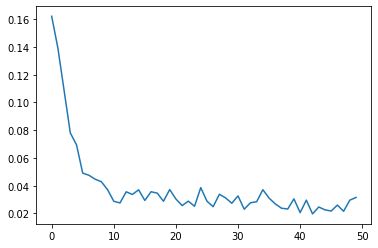

In [13]:
model = train_pipeline.m('unet')

plt.plot(model.loss_list)

In [23]:
train_pipeline.save_model_now('unet', './unet_model')

In [6]:
model_config = {
    "build": False,
    "load/path": './unet_model'
}

predict_pipeline = (dataset.p
    .init_model("static", UNet, 'unet', config=model_config)                
    .init_variable('res', [])
    .init_variable('raw', [])
    .init_variable('lift', [])
    .load(src=['raw', 'lift'], components=['raw', 'lift'], fmt='segy', limits=[0, 3000])
    .update(V('raw', mode='a'), SU('raw').data)
    .update(V('lift', mode='a'), SU('lift').data)
    .predict_model('unet', 
                   images=SU('raw').data,
                   fetches='predictions',
                   save_to=V('res', mode='a'))
)

In [7]:
predict_pipeline.run(BATCH_SIZE, n_iters=35, drop_last=True, shuffle=False, bar=True)

100%|███████████████████████████████████████████| 35/35 [00:25<00:00,  1.39it/s]


In [8]:
res = np.squeeze(np.vstack(predict_pipeline.v("res")))
raw = np.vstack(np.concatenate(predict_pipeline.v("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.v("lift")))

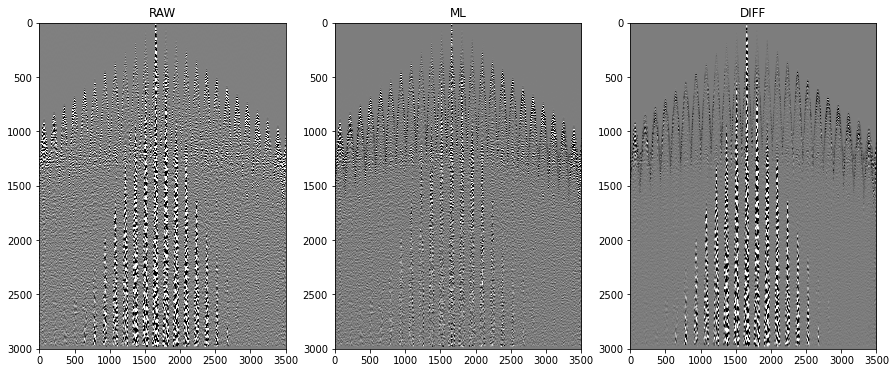

In [10]:
from seismicpro.src import seismic_plot
seismic_plot([raw, res, res - raw], names=['RAW', 'ML', 'DIFF'],
             figsize=(15, 6), vmin=-0.1, vmax=0.1, cmap='gray')